# Encoding using multiple harmonics gives worse noise resilience in the worst case than using just one

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
plt.style.use('seaborn-v0_8-notebook')
np.random.seed(7) # seed so plots are repeatable
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [8,6]) # paper figures should be width 8 (full linewidth) to have nicely readable text

In [2]:
N = 8
neuron_indices = np.atleast_2d(np.arange(N)).T

activity = lambda theta, fs, scaled: np.sum([np.cos(-theta*(f if scaled else 1) + 2*np.pi*f*neuron_indices/N) for f in fs], axis=0)

neuron_index_to_xy = lambda index: (np.cos(2*np.pi*index/N), np.sin(2*np.pi*index/N))
cos_sin = lambda x: (np.cos(x), np.sin(x))

# for a particular harmonic -> output activity with that harmonic
harmonic_encoder = lambda f: lambda r, theta: r*activity(theta, [f], True)

# decode activity with a particular harmonic into either (X,Y) position, angle, or distance
# For higher harmonics, output all f possible decodings for the all_ decoders
get_psuedo_inv_T = lambda f: np.linalg.pinv(np.hstack(neuron_index_to_xy(f*neuron_indices)))
decoder = lambda f: (lambda pseudo_inv_T: lambda a: (pseudo_inv_T @ a)) (get_psuedo_inv_T(f))
decoding_to_angle = lambda decoding, f: 1/f*np.arctan2(*decoding[::-1,:])
decoding_to_distance = lambda decoding: np.sqrt(np.sum(decoding**2, axis=0))
first_angle_decoder = lambda f: (lambda decode: lambda a: decoding_to_angle(decode(a), f)) (decoder(f))
distance_decoder = lambda f: (lambda decode: lambda a: decoding_to_distance(decode(a))) (decoder(f))
first_xy_decoder = lambda f: (lambda first_angle_decoder, distance_decoder: lambda a: distance_decoder(a)*cos_sin(first_angle_decoder(a))) (first_angle_decoder(f), distance_decoder(f))
all_angles_decoder = lambda f: (lambda decode: lambda a: 2*np.pi/f*np.atleast_2d(np.arange(f)).T + decoding_to_angle(decode(a), f)) (decoder(f))
all_xy_decoder = lambda f: (lambda all_angles_decoder, distance_decoder: lambda a: distance_decoder(a)*cos_sin(all_angles_decoder(a))) (all_angles_decoder(f), distance_decoder(f))

# create the 2D likelihood distribution for a certain harmonic from some activity
grid_x, grid_y = np.meshgrid(np.arange(-2.5,2.5,0.025), np.arange(0-2.5,2.5,0.025))
sigma = 0.5
gaussian2d = lambda x, y, sigma, mu_x, mu_y: 1/(2*np.pi*sigma**2) * np.exp(-((x-mu_x)**2 + (y - mu_y)**2) / sigma**2)
likelihood_distribution = lambda f: lambda a: np.mean(np.dstack([gaussian2d(grid_x, grid_y, sigma, *xy.ravel()) for xy in all_xy_decoder(f)(a)[:,:,0].T]), axis=2)

def decode_likelihood_xy(likelihood_distribution):
    max_index = np.argmax(likelihood_distribution)
    return grid_x.ravel()[max_index], grid_y.ravel()[max_index]

def decode_multi_likelihood_xy(f, likelihood_distribution):
    likelihood_distribution = likelihood_distribution.copy()
    peaks = []
    for _ in range(f):
        max_index = np.argmax(likelihood_distribution)
        peaks.append([grid_x.ravel()[max_index], grid_y.ravel()[max_index]])
        likelihood_distribution.ravel()[:][max_index] = 0
    return np.array(peaks)

def decode_likelihood_theta(likelihood_distribution):
    max_index = np.argmax(likelihood_distribution)
    return np.arctan2(grid_y.ravel()[max_index], grid_x.ravel()[max_index])

def plot_likelihood_distribution(likelihood_distribution):
    # plt.pcolormesh(grid_x, grid_y, likelihood_distribution, shading='gouraud', cmap='Blues')
    plt.contourf(grid_x, grid_y, likelihood_distribution, cmap='Blues', alpha=0.8)

## An example of the fragility of encoding using multiple harmonics

If we encode with multiple harmonics (eg. $f=1$ and $f=2$) the second frequency encodes 2 representations $180^\circ$ apart. This ambiguity can only be resolved by choosing the representation closest to that encoded by $f=1$. But if this is sufficiently corrupted with noise the decoding of the second harmonic will be wrong.

An example is shown below -- we have a likelihood distribution centred around each of the encoded bumps for each harmonic, then the overall decoding is the maximum of the joint likelihood.

encoded xy = [1.0,0.0]
decoded xy = [-0.6750000000000065,-0.050000000000008704]


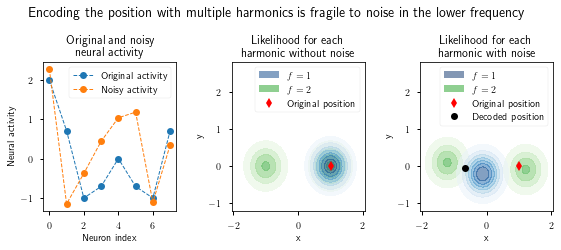

In [3]:
np.random.seed(17) # a nice example

fig, axs = plt.subplots(1, 3, figsize=(8,3.5))

r0 = 1
theta0 = 0

a0 = r0 * activity(theta0, [1,2], True)
a = a0 + np.random.randn(*a0.shape)
f1_L = likelihood_distribution(1)(a)
f2_L = likelihood_distribution(2)(a)
decode_x, decode_y = decode_likelihood_xy(f1_L*f2_L)

plt.sca(axs[0])
plt.plot(a0, 'o--', lw=1, label='Original activity')
plt.plot(a, 'o--', lw=1, label='Noisy activity')
plt.legend()
plt.xlabel('Neuron index')
plt.ylabel('Neural activity')
plt.title('Original and noisy\nneural activity')

plt.sca(axs[1])
c2 = plt.contourf(grid_x, grid_y, likelihood_distribution(2)(a0), levels=np.linspace(0.05, likelihood_distribution(1)(a0).max(), 8), cmap='Greens', alpha=0.8)
c1 = plt.contourf(grid_x, grid_y, likelihood_distribution(1)(a0), levels=np.linspace(0.05, likelihood_distribution(1)(a0).max(), 8), cmap='Blues', alpha=0.5)
r1 = plt.Rectangle((0, 0), 1, 1, fc=c1.tcolors[np.count_nonzero(c1.levels <= f1_L.max()) - 1][0], label='$f=1$')
r2 = plt.Rectangle((0, 0), 1, 1, fc=c2.tcolors[np.count_nonzero(c2.levels <= f2_L.max()) - 1][0], label='$f=2$')
plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
plt.legend(handles=[r1, r2] + axs[1].patches + axs[1].lines)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-2.05,2.05)
plt.ylim(-1.2,2.8)
plt.title('Likelihood for each\nharmonic without noise')

plt.sca(axs[2])
c2 = plt.contourf(grid_x, grid_y, f2_L, cmap='Greens', alpha=0.8, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
c1 = plt.contourf(grid_x, grid_y, f1_L, cmap='Blues', alpha=0.5, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
r1 = plt.Rectangle((0, 0), 1, 1, fc=c1.tcolors[np.count_nonzero(c1.levels <= f1_L.max()) - 1][0], label='$f=1$')
r2 = plt.Rectangle((0, 0), 1, 1, fc=c2.tcolors[np.count_nonzero(c2.levels <= f2_L.max()) - 1][0], label='$f=2$')
plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
plt.plot(decode_x, decode_y, 'ko', label='Decoded position')
plt.legend(handles=[r1, r2] + axs[2].patches + axs[2].lines)
# plt.legend(handles=[r1, r2, r3] + axs[2].patches + axs[2].lines)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-2.05,2.05)
plt.ylim(-1.2,2.8)
plt.title('Likelihood for each\nharmonic with noise')

print(f'encoded xy = [{r0*np.cos(theta0)},{r0*np.sin(theta0)}]')
print(f'decoded xy = [{decode_x},{decode_y}]')

plt.suptitle(f'Encoding the position with multiple harmonics is fragile to noise in the lower frequency', fontsize=14)
plt.tight_layout()
plt.savefig('plots/combined-harmonics-error-snapping-example.pdf')
plt.show()

## Position decoding

### $f=1$ and $f=2$
Here the decoded position jumps to the wrong $f=2$ bump when the first harmonic crosses the origin, a distance of $1r$ from original bump location

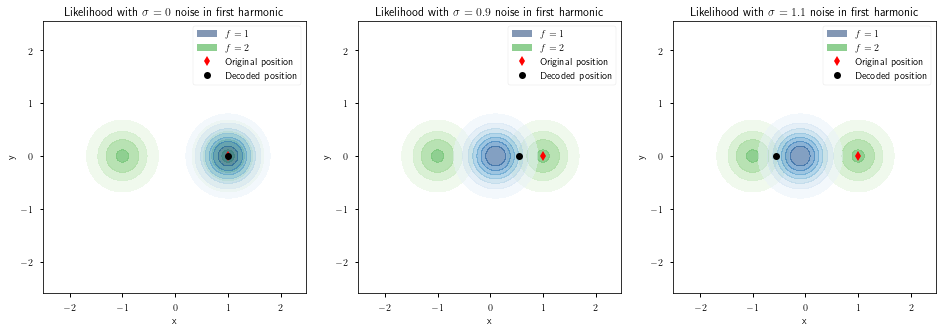

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))

a0 = r0 * activity(theta0, [1,2], True)

for noise, ax in zip([0, 0.9, 1.1], axs):
	a = a0 - noise*np.cos(2*np.pi*neuron_indices/N)
	f1_L = likelihood_distribution(1)(a)
	f2_L = likelihood_distribution(2)(a)
	decode_x, decode_y = decode_likelihood_xy(f1_L*f2_L)
	plt.sca(ax)
	# plot_likelihood_distribution(f1_L + f2_L)
	c2 = plt.contourf(grid_x, grid_y, f2_L, cmap='Greens', alpha=0.8, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
	c1 = plt.contourf(grid_x, grid_y, f1_L, cmap='Blues', alpha=0.5, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
	r1 = plt.Rectangle((0, 0), 1, 1, fc=c1.tcolors[np.count_nonzero(c1.levels <= f1_L.max()) - 1][0], label='$f=1$')
	r2 = plt.Rectangle((0, 0), 1, 1, fc=c2.tcolors[np.count_nonzero(c2.levels <= f2_L.max()) - 1][0], label='$f=2$')
	plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
	plt.plot(decode_x, decode_y, 'ko', label='Decoded position')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.legend(handles=[r1, r2] + ax.patches + ax.lines)
	plt.title(f'Likelihood with $\\sigma={noise}$ noise in first harmonic')
	plt.axis('equal')
# plt.tight_layout()
plt.show()

### $f=1$ and $f=3$
Now the decoded position jumps to the wrong $f=3$ bump when the first harmonic is closer to either of the other bumps, a distance of $\sin(60^\circ)r = 0.866r$ from original bump location.

The direction is $\frac{5\pi}{6}$ from the origin

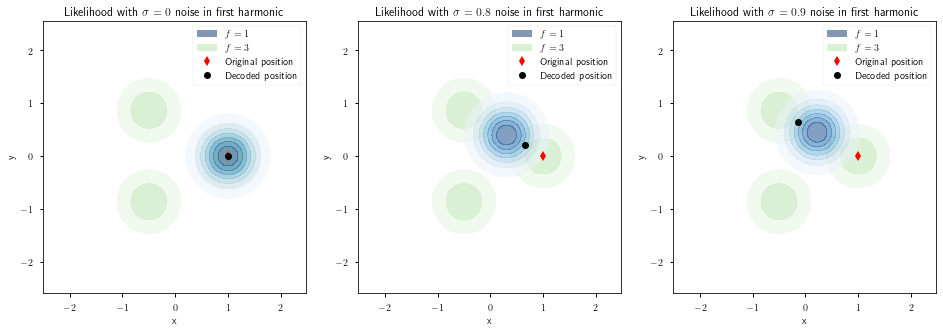

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))

a0 = r0 * activity(theta0, [1,3], True)

for noise, ax in zip([0, 0.8, 0.9], axs):
	a = a0 + noise*np.cos(2*np.pi*neuron_indices/N - 5*np.pi/6)
	f1_L = likelihood_distribution(1)(a)
	f3_L = likelihood_distribution(3)(a)
	decode_x, decode_y = decode_likelihood_xy(f1_L*f3_L)
	plt.sca(ax)
	# plot_likelihood_distribution(f1_L + f3_L)
	c3 = plt.contourf(grid_x, grid_y, f3_L, cmap='Greens', alpha=0.8, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
	c1 = plt.contourf(grid_x, grid_y, f1_L, cmap='Blues', alpha=0.5, levels=np.linspace(0.05, f1_L.max(), 8), extend='max')
	r1 = plt.Rectangle((0, 0), 1, 1, fc=c1.tcolors[np.count_nonzero(c1.levels <= f1_L.max()) - 1][0], label='$f=1$')
	r3 = plt.Rectangle((0, 0), 1, 1, fc=c3.tcolors[np.count_nonzero(c3.levels <= f3_L.max()) - 1][0], label='$f=3$')
	plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
	plt.plot(decode_x, decode_y, 'ko', label='Decoded position')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.legend(handles=[r1, r3] + ax.patches + ax.lines)
	plt.title(f'Likelihood with $\\sigma={noise}$ noise in first harmonic')
	plt.axis('equal')
plt.show()

### $f=2$ and $f=3$

Adding noise to a harmonic that isn't $f=1$ moves the decoded position in a nonlinear way (because the encoding is nonlinear for higher frequencies so they rotate at the same speed as the $f=1$ bump)

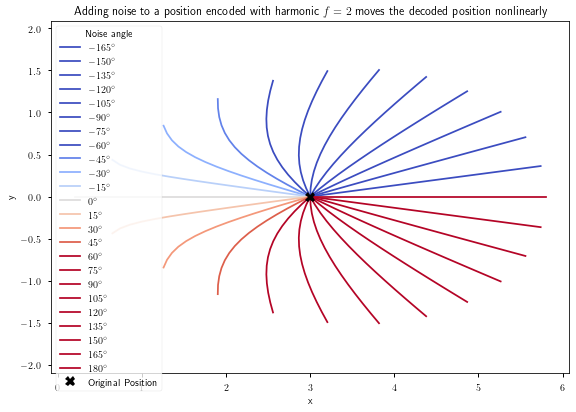

In [6]:
a0 = 3 * activity(theta0, [2], True)

noise_mag_range = np.arange(0, 3, 0.2)

for noise_angle in np.arange(-165, 182, 15):
	points = np.array([first_xy_decoder(2)(a0 - noise_mag*np.cos(2*2*np.pi*neuron_indices/N - np.radians(noise_angle))) for noise_mag in noise_mag_range])
	plt.plot(points[:,0], points[:,1], color=plt.colormaps.get_cmap('coolwarm')(1/120*(60+noise_angle)), label=f'${noise_angle:.0f}^\\circ$')
plt.plot(3, 0, 'kX', ms=10, label='Original Position')
plt.legend(title='Noise angle')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adding noise to a position encoded with harmonic $f=2$ moves the decoded position nonlinearly')
plt.axis('equal')
plt.tight_layout()
plt.show()

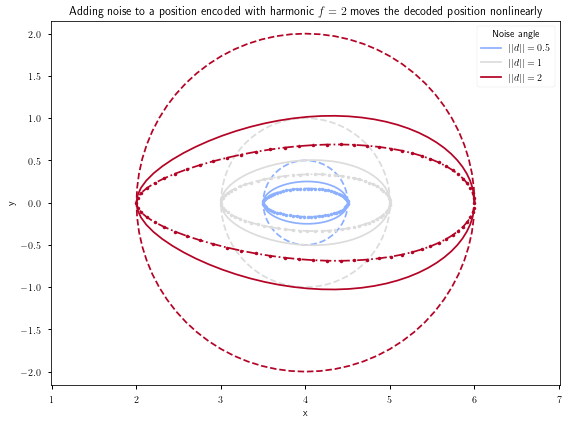

In [7]:
a0 = 4 * activity(0, [1,2,3], True)

noise_mag_range = [0.5,1,2]
noise_angle_range = np.arange(-180, 180, 5)

for noise_mag in noise_mag_range:
	points = np.array([first_xy_decoder(2)(a0 - noise_mag*np.cos(2*2*np.pi*neuron_indices/N - np.radians(noise_angle))) for noise_angle in noise_angle_range])
	pointsf1 = np.array([first_xy_decoder(1)(a0 - noise_mag*np.cos(2*np.pi*neuron_indices/N - np.radians(noise_angle))) for noise_angle in noise_angle_range])
	pointsf3 = np.array([first_xy_decoder(3)(a0 - noise_mag*np.cos(2*3*np.pi*neuron_indices/N - np.radians(noise_angle))) for noise_angle in noise_angle_range])
	plt.plot(points[:,0], points[:,1], color=plt.colormaps.get_cmap('coolwarm')(noise_mag/2), label=f'$||d||={noise_mag}$')
	plt.plot(pointsf1[:,0], pointsf1[:,1], '--', color=plt.colormaps.get_cmap('coolwarm')(noise_mag/2))
	plt.plot(pointsf3[:,0], pointsf3[:,1], '.-.', color=plt.colormaps.get_cmap('coolwarm')(noise_mag/2))
# plt.plot(1, 0, 'kX', ms=10, label='Original Position')
plt.legend(title='Noise angle')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Adding noise to a position encoded with harmonic $f=2$ moves the decoded position nonlinearly')
plt.tight_layout()
plt.show()

In this case the direction of the noise that needs to be added is more difficult to determine, from later experimentation we see the angle 0.7 works with a noise magnitude of 0.9

Alternatively we could also change the scaling so $f=2$ is the base frequency and in unscaled, and $f=3$ moves at $3/2$ of its normal speed

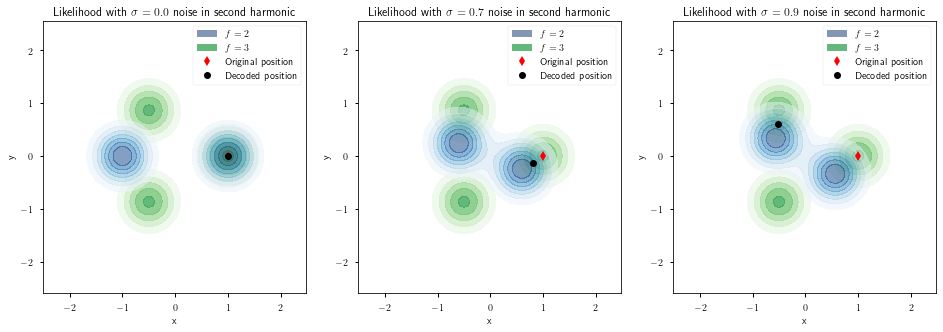

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(16,5))

a0 = r0 * activity(theta0, [2,3], True)

for noise, ax in zip([0.0, 0.7, 0.9], axs):
	noise_vector = np.cos(2*2*np.pi*neuron_indices/N - 0.7)
	a = a0 - noise*noise_vector
	f2_L = likelihood_distribution(2)(a)
	f3_L = likelihood_distribution(3)(a)
	decode_x, decode_y = decode_likelihood_xy(f2_L * f3_L)
	plt.sca(ax)
	# plot_likelihood_distribution(f2_L)
	# plot_likelihood_distribution(f2_L + f3_L)
	c3 = plt.contourf(grid_x, grid_y, f3_L, cmap='Greens', alpha=0.8, levels=np.linspace(0.05, f2_L.max(), 8), extend='max')
	c2 = plt.contourf(grid_x, grid_y, f2_L, cmap='Blues', alpha=0.5, levels=np.linspace(0.05, f2_L.max(), 8), extend='max')
	r2 = plt.Rectangle((0, 0), 1, 1, fc=c2.tcolors[np.count_nonzero(c2.levels <= f2_L.max()) - 1][0], label='$f=2$')
	r3 = plt.Rectangle((0, 0), 1, 1, fc=c3.tcolors[np.count_nonzero(c3.levels <= f3_L.max()) - 1][0], label='$f=3$')
	plt.plot(r0*np.cos(theta0), r0*np.sin(theta0), 'rd', label='Original position')
	plt.plot(decode_x, decode_y, 'ko', label='Decoded position')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.legend(handles=[r2, r3] + ax.patches + ax.lines)
	plt.title(f'Likelihood with $\\sigma={noise}$ noise in second harmonic')
	plt.axis('equal')
# plt.tight_layout()
plt.show()

## Checking worst case noise

The average noise energy of a sinusoid is:

$$\|\epsilon\| = \frac{\sqrt{2}}{{2}}$$

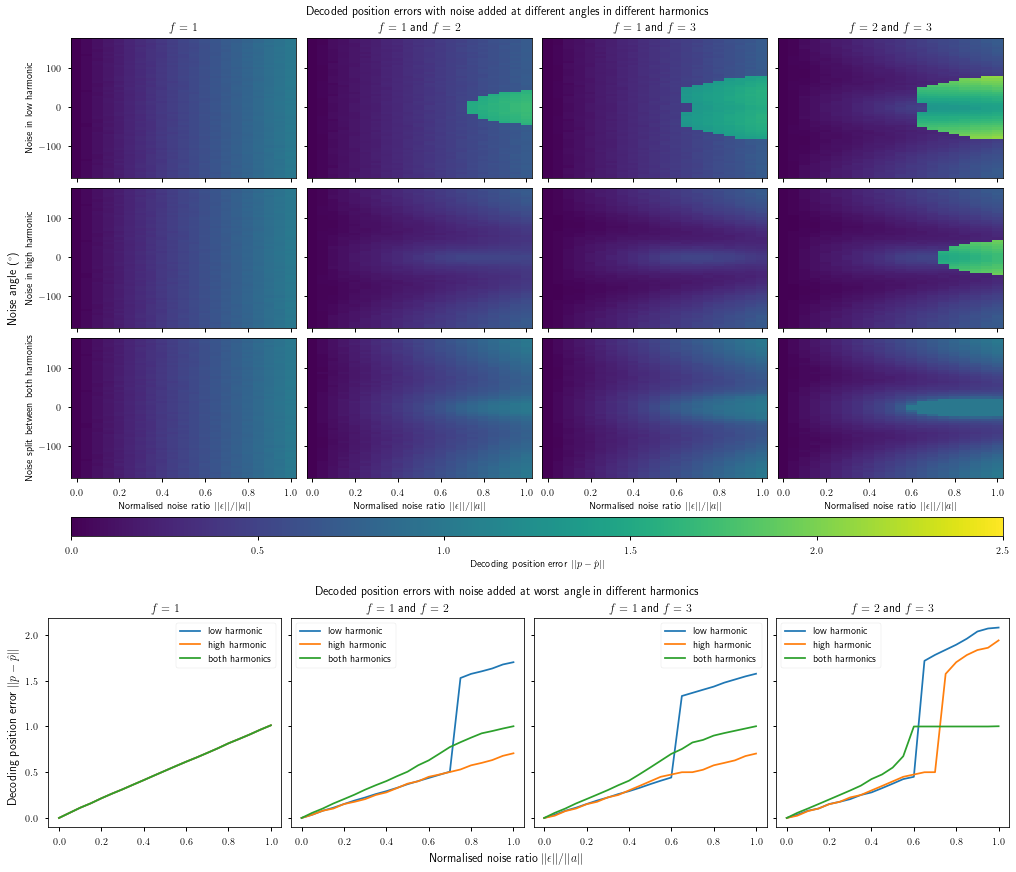

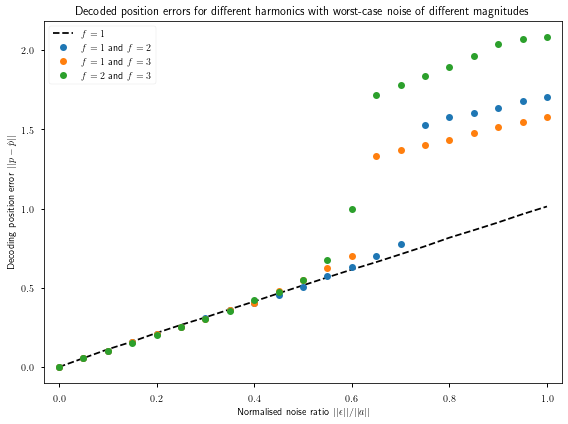

In [9]:
decoding_error = lambda x0, y0, decode_x, decode_y : np.sqrt((decode_x - x0)**2 + (decode_y - y0)**2)
joint_likelihood = lambda fs, a: likelihood_distribution(fs[0])(a) * likelihood_distribution(fs[1])(a) if len(fs) > 1 else likelihood_distribution(fs[0])(a)
fs_to_label = lambda fs: f'$f={fs[0]}$ and $f={fs[1]}$'if len(fs) > 1 else f'$f={fs[0]}$'
# scale noise with number of harmonics (encoded signal energy)
noise_low_harmonic = lambda fs, noise_ratio, noise_angle: np.sqrt(len(fs))*noise_ratio*np.cos(2*fs[0]*np.pi*neuron_indices/N - noise_angle)
noise_high_harmonic = lambda fs, noise_ratio, noise_angle: np.sqrt(len(fs))*noise_ratio*np.cos(2*fs[1]*np.pi*neuron_indices/N - noise_angle) if len(fs)>1 else noise_low_harmonic(fs, noise_ratio, noise_angle)
noise_both_harmonics = lambda fs, noise_ratio, noise_angle: noise_ratio*np.cos(2*fs[0]*np.pi*neuron_indices/N - noise_angle) + noise_ratio*np.cos(2*fs[1]*np.pi*neuron_indices/N - noise_angle) if len(fs)>1 else noise_low_harmonic(fs, noise_ratio, noise_angle)

x0, y0 = r0*np.cos(theta0), r0*np.sin(theta0)

noise_angle_range = np.arange(-np.pi, np.pi, 0.1) 
noise_ratio_range = np.arange(0, 1.02, 0.05)

fig1 = plt.figure(constrained_layout=True, figsize=(14,12))
subfigs = fig1.subfigures(2, 1, hspace=0.03, height_ratios=[2, 1])
img_grid = subfigs[0].subplots(3,4,sharex=True, sharey=True)
error_axs = subfigs[1].subplots(1,4,sharey=True)
fig2, ax1 = plt.subplots(1,1)

f_combinations = [[1], [1,2], [1,3], [2,3]]
all_position_errors = []

for ax_col, error_ax, fs in zip(img_grid.T, error_axs, f_combinations):
	a0 = r0 * activity(theta0, fs, True)
	position_errors = np.zeros((len(noise_angle_range), len(noise_ratio_range), 3))
	for n, (ax, noise_function) in enumerate(zip(ax_col, [noise_low_harmonic,noise_high_harmonic,noise_both_harmonics])):
		for i, noise_angle in enumerate(noise_angle_range):
			for j, noise_ratio in enumerate(noise_ratio_range):
				position_errors[i,j,n] = decoding_error(x0, y0, *decode_likelihood_xy(joint_likelihood(fs, a0 - noise_function(fs, noise_ratio, noise_angle))))
		im = ax.pcolor(noise_ratio_range, np.degrees(noise_angle_range), position_errors[:,:,n], vmin=0, vmax=2.5)
		error_ax.plot(noise_ratio_range, np.max(position_errors[:,:,n], axis=0), label=['low harmonic','high harmonic','both harmonics'][n])
	all_position_errors.append(position_errors)
	
	ax_col[0].set_title(f'{fs_to_label(fs)}')
	error_ax.set_title(f'{fs_to_label(fs)}')
	error_ax.legend()

	ax1.plot(noise_ratio_range, np.max(np.max(position_errors, axis=2), axis=0), 'o' if len(fs) == 2 else 'k--', label=fs_to_label(fs))

subfigs[0].colorbar(im, ax=img_grid, location='bottom', pad=0.01, aspect=50).set_label('Decoding position error $||p - \\hat p||$')
for ax, title in zip(img_grid[:,0], ['in low harmonic', 'in high harmonic', 'split between both harmonics']):
	ax.set_ylabel(f'Noise {title}')
for ax in img_grid[2,:]:
	ax.set_xlabel('Normalised noise ratio $||\\epsilon|| / ||a||$')
subfigs[0].supylabel('Noise angle (${}^\\circ$)')
subfigs[1].supylabel('Decoding position error $||p - \\hat p||$')
subfigs[1].supxlabel('Normalised noise ratio $||\\epsilon|| / ||a||$')

subfigs[0].suptitle('Decoded position errors with noise added at different angles in different harmonics')
subfigs[1].suptitle('Decoded position errors with noise added at worst angle in different harmonics')

ax1.legend()
ax1.set_xlim(-0.03,1.03)
ax1.set_title('Decoded position errors for different harmonics with worst-case noise of different magnitudes')
ax1.set_ylabel('Decoding position error $||p - \\hat p||$')
ax1.set_xlabel('Normalised noise ratio $||\\epsilon|| / ||a||$')
fig2.tight_layout()

plt.show()

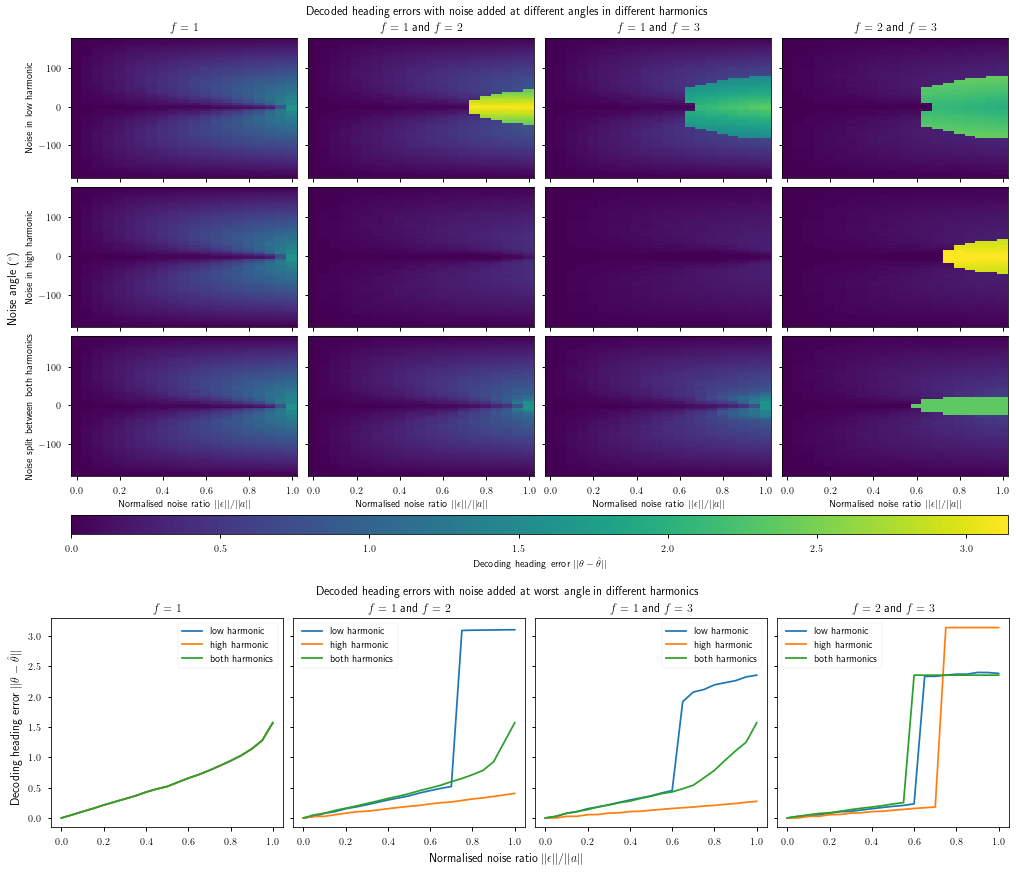

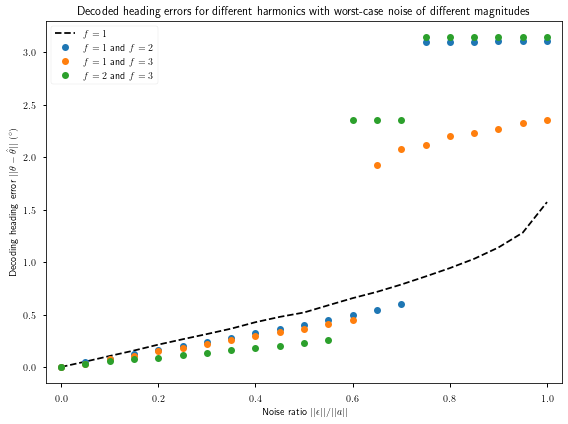

In [14]:
decoding_error_heading = lambda theta0, decode_theta : abs(theta0 - decode_theta)

noise_angle_range = np.arange(-np.pi, np.pi, 0.1) 
noise_ratio_range = np.arange(0, 1.02, 0.05)

fig1 = plt.figure(constrained_layout=True, figsize=(14,12))
subfigs = fig1.subfigures(2, 1, hspace=0.03, height_ratios=[2, 1])
img_grid = subfigs[0].subplots(3,4,sharex=True, sharey=True)
error_axs = subfigs[1].subplots(1,4,sharey=True)
fig2, ax1 = plt.subplots(1,1)

f_combinations = [[1], [1,2], [1,3], [2,3]]
all_heading_errors = []

for ax_col, error_ax, fs in zip(img_grid.T, error_axs, f_combinations):
	a0 = r0 * activity(theta0, fs, True)
	heading_errors = np.zeros((len(noise_angle_range), len(noise_ratio_range), 3))
	for n, (ax, noise_function) in enumerate(zip(ax_col, [noise_low_harmonic,noise_high_harmonic,noise_both_harmonics])):
		for i, noise_angle in enumerate(noise_angle_range):
			for j, noise_ratio in enumerate(noise_ratio_range):
				heading_errors[i,j,n] = decoding_error_heading(theta0, decode_likelihood_theta(joint_likelihood(fs, a0 - noise_function(fs, noise_ratio, noise_angle))))
		im = ax.pcolor(noise_ratio_range, np.degrees(noise_angle_range), heading_errors[:,:,n], vmin=0, vmax=np.pi)
		error_ax.plot(noise_ratio_range, np.max(heading_errors[:,:,n], axis=0), label=['low harmonic','high harmonic','both harmonics'][n])
	all_heading_errors.append(heading_errors)
	
	ax_col[0].set_title(f'{fs_to_label(fs)}')
	error_ax.set_title(f'{fs_to_label(fs)}')
	error_ax.legend()

	ax1.plot(noise_ratio_range, np.max(np.max(heading_errors, axis=2), axis=0), 'o' if len(fs) == 2 else 'k--', label=fs_to_label(fs))

subfigs[0].colorbar(im, ax=img_grid, location='bottom', pad=0.01, aspect=50).set_label('Decoding heading error $||\\theta - \\hat \\theta||$')
for ax, title in zip(img_grid[:,0], ['in low harmonic', 'in high harmonic', 'split between both harmonics']):
	ax.set_ylabel(f'Noise {title}')
for ax in img_grid[2,:]:
	ax.set_xlabel('Normalised noise ratio $||\\epsilon|| / ||a||$')
subfigs[0].supylabel('Noise angle (${}^\\circ$)')
subfigs[1].supylabel('Decoding heading error $||\\theta - \\hat \\theta||$')
subfigs[1].supxlabel('Normalised noise ratio $||\\epsilon|| / ||a||$')

subfigs[0].suptitle('Decoded heading errors with noise added at different angles in different harmonics')
subfigs[1].suptitle('Decoded heading errors with noise added at worst angle in different harmonics')

ax1.legend()
ax1.set_xlim(-0.03,1.03)
ax1.set_title('Decoded heading errors for different harmonics with worst-case noise of different magnitudes')
ax1.set_ylabel('Decoding heading error $||\\theta - \\hat \\theta||$ $({}^\\circ)$')
ax1.set_xlabel('Noise ratio $||\\epsilon|| / ||a||$')
fig2.tight_layout()

plt.show()

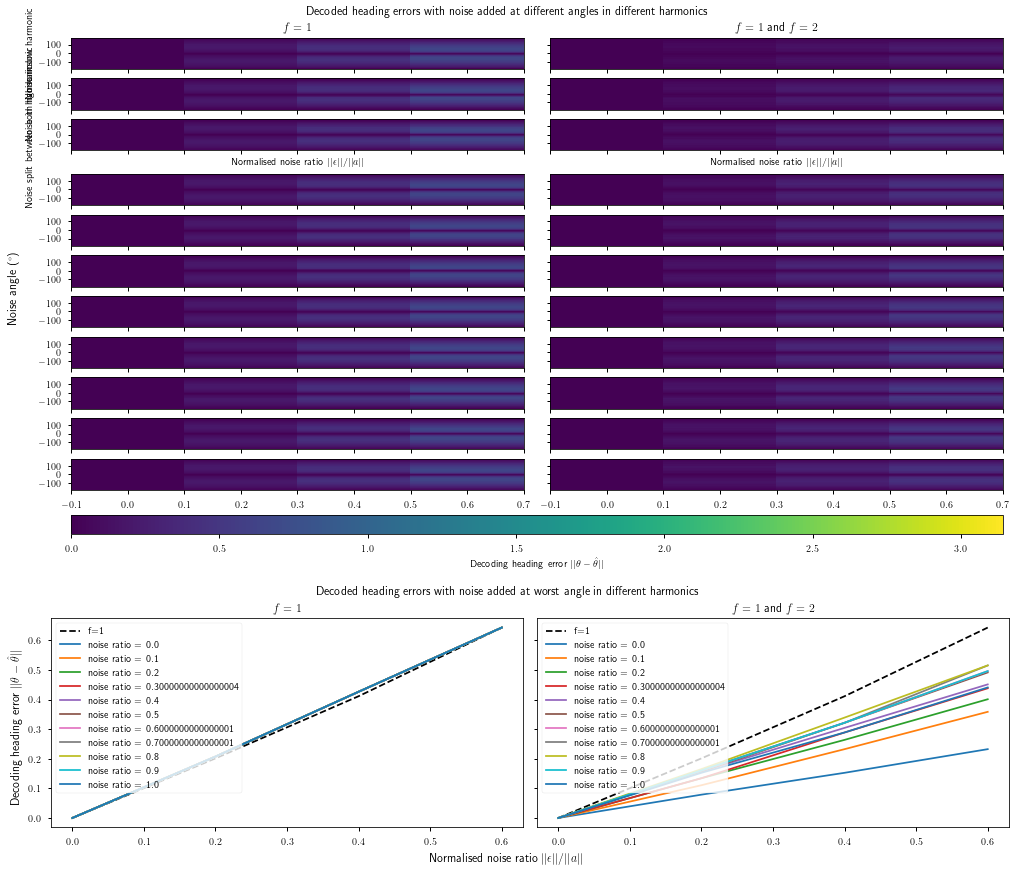

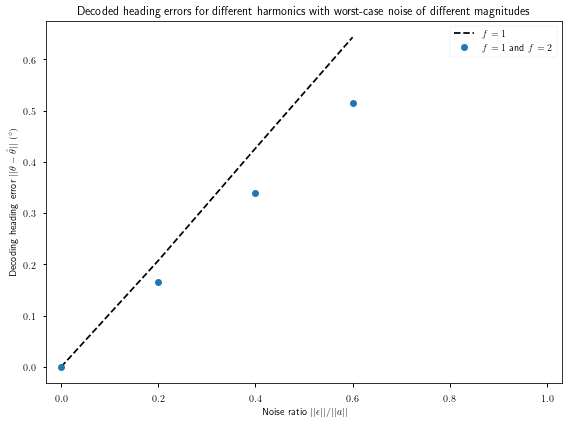

In [11]:
decoding_error_heading = lambda theta0, decode_theta : abs(theta0 - decode_theta)

joint_likelihood = lambda fs, a: likelihood_distribution(fs[0])(a) * likelihood_distribution(fs[1])(a) if len(fs) > 1 else likelihood_distribution(fs[0])(a)
fs_to_label = lambda fs: f'$f={fs[0]}$ and $f={fs[1]}$'if len(fs) > 1 else f'$f={fs[0]}$'
noise_low_harmonic = lambda fs, noise_ratio, noise_angle: np.sqrt(len(fs))*noise_ratio*np.cos(2*fs[0]*np.pi*neuron_indices/N - noise_angle)
noise_high_harmonic = lambda fs, noise_ratio, noise_angle: np.sqrt(len(fs))*noise_ratio*np.cos(2*fs[1]*np.pi*neuron_indices/N - noise_angle) if len(fs)>1 else noise_low_harmonic(fs, noise_ratio, noise_angle)
noise_both_harmonics = lambda fs, noise_ratio, noise_angle: noise_ratio*np.cos(2*fs[0]*np.pi*neuron_indices/N - noise_angle) + noise_ratio*np.cos(2*fs[1]*np.pi*neuron_indices/N - noise_angle) if len(fs)>1 else noise_low_harmonic(fs, noise_ratio, noise_angle)

noise_in_harmonic_with_ratio = lambda fs, noise_amount, ratio, noise_angle: np.sqrt(len(fs)*ratio)*noise_amount*np.cos(2*fs[0]*np.pi*neuron_indices/N - noise_angle) + np.sqrt(len(fs)*(1-ratio))*noise_amount*np.cos(2*fs[1]*np.pi*neuron_indices/N - noise_angle) if len(fs)>1 else noise_amount*np.cos(2*fs[0]*np.pi*neuron_indices/N - noise_angle)


noise_angle_range = np.arange(-np.pi, np.pi, 0.2) 
noise_ratio_range = np.arange(0, 0.7, 0.2)

fig1 = plt.figure(constrained_layout=True, figsize=(14,12))
subfigs = fig1.subfigures(2, 1, hspace=0.03, height_ratios=[2, 1])
img_grid = subfigs[0].subplots(11,2,sharex=True, sharey=True)
error_axs = subfigs[1].subplots(1,2,sharey=True)
fig2, ax1 = plt.subplots(1,1)

f_combinations = [[1], [1,2]]
all_heading_errors = []

for ax_col, error_ax, fs in zip(img_grid.T, error_axs, f_combinations):
	error_ax.plot(noise_ratio_range, np.arcsin(noise_ratio_range), 'k--', label='f=1')
	a0 = r0 * activity(theta0, fs, True)
	heading_errors = np.zeros((len(noise_angle_range), len(noise_ratio_range), 11))
	for n, (ax, noise_ratio) in enumerate(zip(ax_col, np.linspace(0,1,11))):
		for i, noise_angle in enumerate(noise_angle_range):
			for j, noise_amount in enumerate(noise_ratio_range):
				heading_errors[i,j,n] = decoding_error_heading(theta0, decode_likelihood_theta(joint_likelihood(fs, a0 - noise_in_harmonic_with_ratio(fs, noise_amount, noise_ratio, noise_angle))))
		im = ax.pcolor(noise_ratio_range, np.degrees(noise_angle_range), heading_errors[:,:,n], vmin=0, vmax=np.pi)
		error_ax.plot(noise_ratio_range, np.max(heading_errors[:,:,n], axis=0), label=f'noise ratio = {noise_ratio}')
	all_heading_errors.append(heading_errors)
	
	ax_col[0].set_title(f'{fs_to_label(fs)}')
	error_ax.set_title(f'{fs_to_label(fs)}')
	error_ax.legend()

	ax1.plot(noise_ratio_range, np.max(np.max(heading_errors, axis=2), axis=0), 'o' if len(fs) == 2 else 'k--', label=fs_to_label(fs))

subfigs[0].colorbar(im, ax=img_grid, location='bottom', pad=0.01, aspect=50).set_label('Decoding heading error $||\\theta - \\hat \\theta||$')
for ax, title in zip(img_grid[:,0], ['in low harmonic', 'in high harmonic', 'split between both harmonics']):
	ax.set_ylabel(f'Noise {title}')
for ax in img_grid[2,:]:
	ax.set_xlabel('Normalised noise ratio $||\\epsilon|| / ||a||$')
subfigs[0].supylabel('Noise angle (${}^\\circ$)')
subfigs[1].supylabel('Decoding heading error $||\\theta - \\hat \\theta||$')
subfigs[1].supxlabel('Normalised noise ratio $||\\epsilon|| / ||a||$')

subfigs[0].suptitle('Decoded heading errors with noise added at different angles in different harmonics')
subfigs[1].suptitle('Decoded heading errors with noise added at worst angle in different harmonics')

ax1.legend()
ax1.set_xlim(-0.03,1.03)
ax1.set_title('Decoded heading errors for different harmonics with worst-case noise of different magnitudes')
ax1.set_ylabel('Decoding heading error $||\\theta - \\hat \\theta||$ $({}^\\circ)$')
ax1.set_xlabel('Noise ratio $||\\epsilon|| / ||a||$')
fig2.tight_layout()

plt.show()

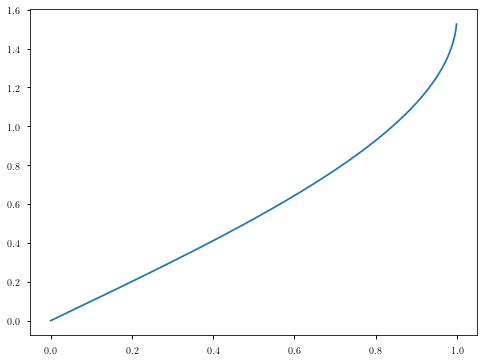

In [12]:
plt.plot(x:=np.arange(0,1,0.001), np.arcsin(x))

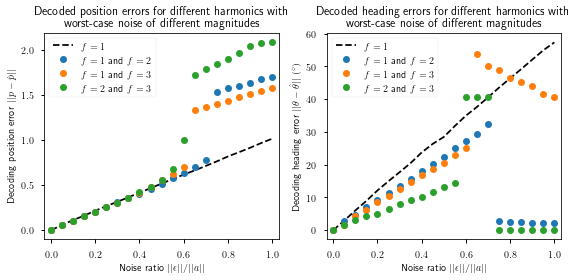

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

for fs, position_errors, heading_errors in zip(f_combinations, all_position_errors, all_heading_errors):
	ax1.plot(noise_ratio_range, np.max(np.max(position_errors, axis=2), axis=0), 'o' if len(fs) == 2 else 'k--', label=fs_to_label(fs))
	ax2.plot(noise_ratio_range, np.degrees(np.sin(np.max(np.max(heading_errors, axis=2), axis=0))), 'o' if len(fs) == 2 else 'k--', label=fs_to_label(fs))

ax1.legend()
ax1.set_xlim(-0.03,1.03)
ax1.set_title('Decoded position errors for different harmonics with\nworst-case noise of different magnitudes')
ax1.set_ylabel('Decoding position error $||p - \\hat p||$')
ax1.set_xlabel('Noise ratio $||\\epsilon|| / ||a||$')

ax2.legend()
ax2.set_xlim(-0.03,1.03)
ax2.set_title('Decoded heading errors for different harmonics with\nworst-case noise of different magnitudes')
ax2.set_ylabel('Decoding heading error $||\\theta - \\hat \\theta||$ $({}^\\circ)$')
ax2.set_xlabel('Noise ratio $||\\epsilon|| / ||a||$')

plt.tight_layout()
plt.savefig('plots/combined-harmonics-worst-case-error.pdf')
plt.show()

### Mean error with random Gaussian noise

The average noise energy is the expectation of the root mean square of a Gaussian sample for each neuron

$$\|\epsilon\| = \mathbb{E}\left[\sqrt{\frac{1}{N} \sum^N \mathcal{N}(0,\sigma^2)^2}\right]$$

For small $N$ this isn't equal to the variance. For example, for $N=1$ we have

$$\|\epsilon\| = \mathbb{E}\left[|\mathcal{N}(0,\sigma^2)|\right]$$

which is the mean of a [folded normal distribution](https://en.wikipedia.org/wiki/Folded_normal_distribution), so

$$\|\epsilon\| = \sqrt{\frac{2}{\pi}}$$

For higher $N$ we just compute numerical approximations and use this to set the noise ratio $\frac{\|\epsilon\|}{\|a\|}$

In [ ]:
def mean_variance_discrete_gaussian_sample(n: int):
	return np.mean(np.sqrt(np.mean(np.random.randn(n,10000000)**2, axis=0)))

for n in range(1,9):
	print(f'{n} - {mean_variance_discrete_gaussian_sample(n)}')

1 - 0.7978210933935467
2 - 0.8859145755004512
3 - 0.9211904407062125
4 - 0.939977641753459
5 - 0.9513855630368853
6 - 0.9594136095636117
7 - 0.9650347061297482
8 - 0.969231822382148


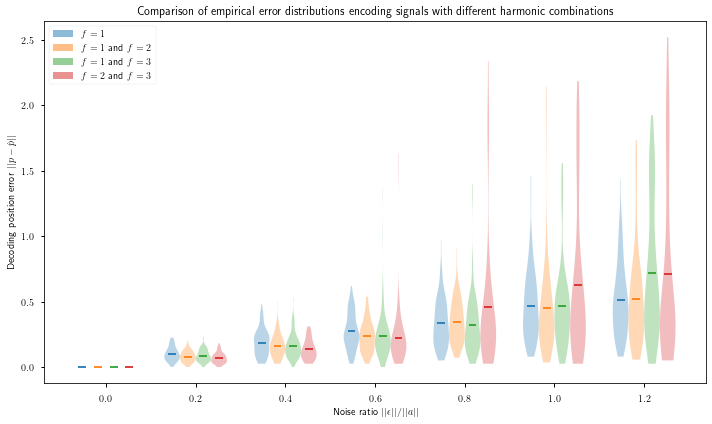

In [ ]:
corrupt_activity = lambda a0, noise_sigma: a0 + noise_sigma*np.random.randn(*a0.shape)

noise_mag_range = np.arange(0, 1.4, 0.2)
x0, y0 = r0*np.cos(theta0), r0*np.sin(theta0)

violin_spacing = 0.035
violin_width = 0.035

for fs,plot_offset in zip([[1], [1,2], [1,3], [2,3]], np.linspace(-3/2,3/2,4)*violin_spacing):
	a0 = r0 * activity(theta0, fs, True)
	# the mean noise energy with 1/0.969*noise_sigma * np.random.randn(8) = noise_sigma^2
	# the mean signal energy is np.sqrt(len(fs))*np.sqrt(2)/2
	# signal_energy = np.sqrt(np.mean(a0**2))
	# avg_noise_energy = np.mean([np.sqrt(np.mean(corrupt_activity(np.zeros_like(a0), 1/0.969*np.sqrt(len(fs))*np.sqrt(2)/2)**2)) for _ in range(10000)])
	# print(f'{avg_noise_energy:.3f}/{signal_energy:.3f}={avg_noise_energy/signal_energy:.3f}')
	plt.violinplot([[decoding_error(x0, y0, *decode_likelihood_xy(joint_likelihood(fs, corrupt_activity(a0, 1/0.969*np.sqrt(len(fs))*np.sqrt(2)/2*noise_mag)))) for _ in range(100)] for noise_mag in noise_mag_range], noise_mag_range+plot_offset, widths=violin_width, showextrema=False, showmeans=True)

plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, alpha=0.5, fc=f'C{n}', label=fs_to_label(fs)) for n, fs in enumerate([[1], [1,2], [1,3], [2,3]])], loc='upper left')

plt.ylabel('Decoding position error $||p - \\hat p||$')
plt.xlabel('Noise ratio $||\\epsilon|| / ||a||$')
plt.title('Comparison of empirical error distributions encoding signals with different harmonic combinations')
plt.tight_layout()
plt.show()

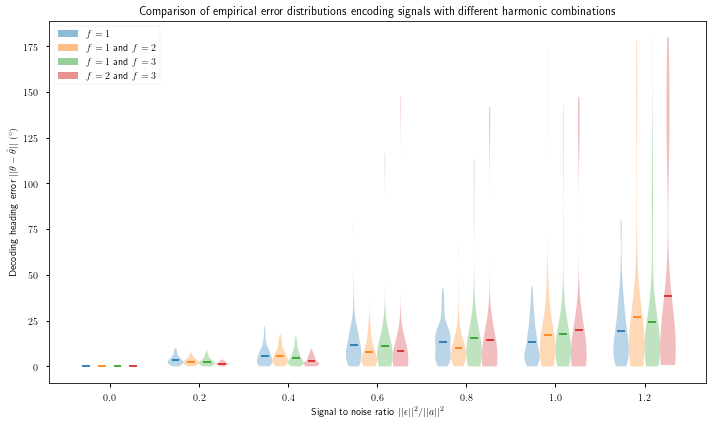

In [ ]:
for fs,plot_offset in zip([[1], [1,2], [1,3], [2,3]], np.linspace(-3/2,3/2,4)*violin_spacing):
	a0 = r0 * activity(theta0, fs, True)
	# the mean noise energy with 1/0.969*noise_sigma * np.random.randn(8) = noise_sigma^2
	# the mean signal energy is np.sqrt(len(fs))*np.sqrt(2)/2
	# signal_energy = np.sqrt(np.mean(a0**2))
	# avg_noise_energy = np.mean([np.sqrt(np.mean(corrupt_activity(np.zeros_like(a0), 1/0.969*np.sqrt(len(fs))*np.sqrt(2)/2)**2)) for _ in range(10000)])
	# print(f'{avg_noise_energy:.3f}/{signal_energy:.3f}={avg_noise_energy/signal_energy:.3f}')
	plt.violinplot([[np.degrees(decoding_error_heading(theta0, decode_likelihood_theta(joint_likelihood(fs, corrupt_activity(a0, 1/0.969*np.sqrt(len(fs))*np.sqrt(2)/2*noise_mag))))) for _ in range(100)] for noise_mag in noise_mag_range], noise_mag_range+plot_offset, widths=violin_width, showextrema=False, showmeans=True)

plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, alpha=0.5, fc=f'C{n}', label=fs_to_label(fs)) for n, fs in enumerate([[1], [1,2], [1,3], [2,3]])], loc='upper left')

plt.ylabel('Decoding heading error $||\\theta - \\hat \\theta||$ $({}^\\circ)$')
plt.xlabel('Signal to noise ratio $||\\epsilon||^2 / ||a||^2$')
plt.title('Comparison of empirical error distributions encoding signals with different harmonic combinations')
plt.tight_layout()
plt.show()